In [2]:
import pandas as pd
from pathlib import Path
import torch
import sys
sys.path.append('src')

# from models.ae_kan import KANAutoencoder
from src.utils.new_preprocessing import preprocessing_dataset, simple_train_kan, change_hyperparam

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Total memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
    print(f"Memory available: {torch.cuda.mem_get_info()[0] / 1024**3:.1f} GB")

print(f"Device : {device}")

GPU: NVIDIA GeForce RTX 3070 Laptop GPU
Total memory: 8.0 GB
Memory available: 6.9 GB
Device : cuda


In [3]:
data_dir = Path("data/processed/sectors")
sectors_list = [d.name for d in data_dir.iterdir() if d.is_dir() and d.name != 'unknown']

sector_log_returns = {}
for sector in sectors_list:
    returns_path = data_dir / sector / "log_returns.csv"
    df = pd.read_csv(returns_path, index_col=0)
    sector_log_returns[sector] = df.iloc[1:]  # Skip first row with NaN values

In [4]:
# Cellule de préparation des données avec split temporel
X_df = {}
W_df = {}
M_df = {}
data = {}

for sector in sector_log_returns:
    # Preprocess data for each sector
    X_df[sector], W_df[sector], M_df[sector] = preprocessing_dataset(
        log_returns_df=sector_log_returns[sector],
        win=60,
        min_periods=40,
        clip_val=3.0,
        min_valid_per_day=5,
        use_median=True,
        soft_weights=True
    )
    
    # Create tensors for each sector
    tensors = {
        'X': torch.tensor(X_df[sector].values, dtype=torch.float32),
        'W': torch.tensor(W_df[sector].values, dtype=torch.float32),
        'M': torch.tensor(M_df[sector].values, dtype=torch.float32)
    }

    total_samples = len(tensors['X'])
    
    # Configuration temporelle
    train_ratio = 0.7      # 70% pour l'entraînement
    val_ratio = 0.15       # 15% pour la validation 
    test_ratio = 0.15      # 15% pour le test
    
    train_end = int(total_samples * train_ratio)
    val_end = int(total_samples * (train_ratio + val_ratio))
    
    data[sector] = {
        'train': {
            'X': tensors['X'][:train_end],
            'W': tensors['W'][:train_end],
            'M': tensors['M'][:train_end]
        },
        'val': {
            'X': tensors['X'][train_end:val_end],
            'W': tensors['W'][train_end:val_end],
            'M': tensors['M'][train_end:val_end]
        },
        'test': {
            'X': tensors['X'][val_end:],
            'W': tensors['W'][val_end:],
            'M': tensors['M'][val_end:]
        }
    }

print(f"📊 Train: {data[sector]['train']['X'].shape[0]} échantillons")
print(f"📊 Val: {data[sector]['val']['X'].shape[0]} échantillons") 
print(f"📊 Test: {data[sector]['test']['X'].shape[0]} échantillons")
print(f"📅 Dates train: {X_df[sector].index[0]} à {X_df[sector].index[train_end-1]}")
print(f"📅 Dates val: {X_df[sector].index[train_end]} à {X_df[sector].index[val_end-1]}")
print(f"📅 Dates test: {X_df[sector].index[val_end]} à {X_df[sector].index[-1]}")

📊 Train: 2613 échantillons
📊 Val: 560 échantillons
📊 Test: 561 échantillons
📅 Dates train: 2010-03-03 à 2020-07-17
📅 Dates val: 2020-07-20 à 2022-10-06
📅 Dates test: 2022-10-07 à 2024-12-31


In [5]:
log_returns_df = pd.read_csv("data/processed/dataset_log_returns.csv", index_col=0)
log_returns_df = log_returns_df.iloc[1:]

In [6]:
# Pareil pour le dataset complet S&P 500
sp500_X_df, sp500_W_df, sp500_M_df = preprocessing_dataset(
    log_returns_df=log_returns_df,
    win=60,
    min_periods=40, 
    clip_val=3.0,
    min_valid_per_day=5,
    use_median=True,
    soft_weights=True
)

sp500_tensors = {
    'X': torch.tensor(sp500_X_df.values, dtype=torch.float32),
    'W': torch.tensor(sp500_W_df.values, dtype=torch.float32), 
    'M': torch.tensor(sp500_M_df.values, dtype=torch.float32)
}

# 🕒 SPLIT TEMPOREL pour S&P 500
total_samples = len(sp500_tensors['X'])
train_end = int(total_samples * 0.7)
val_end = int(total_samples * 0.85)

full_data = {
    'train': {
        'X': sp500_tensors['X'][:train_end],
        'W': sp500_tensors['W'][:train_end],
        'M': sp500_tensors['M'][:train_end]
    },
    'val': {
        'X': sp500_tensors['X'][train_end:val_end],
        'W': sp500_tensors['W'][train_end:val_end],
        'M': sp500_tensors['M'][train_end:val_end]
    },
    'test': {
        'X': sp500_tensors['X'][val_end:],
        'W': sp500_tensors['W'][val_end:],
        'M': sp500_tensors['M'][val_end:]
    }
}

print(f"📊 Train: {full_data['train']['X'].shape[0]} échantillons")
print(f"📊 Val: {full_data['val']['X'].shape[0]} échantillons")
print(f"📊 Test: {full_data['test']['X'].shape[0]} échantillons")
print(f"📅 Dates train: {sp500_X_df.index[0]} à {sp500_X_df.index[train_end-1]}")
print(f"📅 Dates val: {sp500_X_df.index[train_end]} à {sp500_X_df.index[val_end-1]}")
print(f"📅 Dates test: {sp500_X_df.index[val_end]} à {sp500_X_df.index[-1]}")

📊 Train: 2613 échantillons
📊 Val: 560 échantillons
📊 Test: 561 échantillons
📅 Dates train: 2010-03-03 à 2020-07-17
📅 Dates val: 2020-07-20 à 2022-10-06
📅 Dates test: 2022-10-07 à 2024-12-31


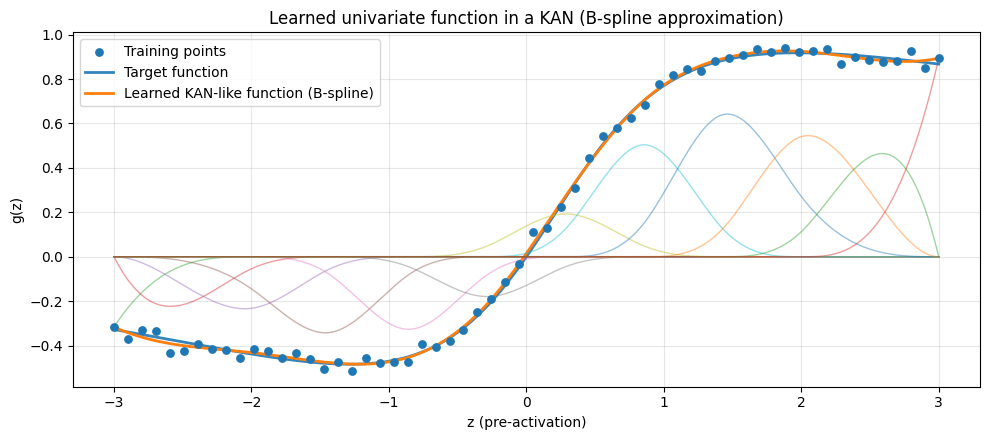

Alpha (spline coefficients):
[-0.3167 -0.4095 -0.4071 -0.4873 -0.4901 -0.2691  0.2891  0.756   0.914
  0.9474  0.8517  0.8937]


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_lsq_spline, BSpline

# 1) Données d'entraînement (fonction cible "nonlinéaire" typique)
rng = np.random.default_rng(42)

def target_fn(z):
    # Une non-linéarité plausible (lisse, saturante + léger bombement)
    return 0.9*np.tanh(1.1*z) + 0.3*(z**2)/(1+z**2) - 0.1*z

# Domaine et échantillonnage
z_train = np.linspace(-3.0, 3.0, 60)
y_train = target_fn(z_train) + 0.03 * rng.normal(size=z_train.size)  # bruit léger

# 2) Construction d'une B-spline (simule la "fonction apprise" d'un KAN)
k = 3  # degré (cubic spline)
# Nœuds intérieurs (on évite les bords pour make_lsq_spline)
t_internal = np.linspace(-2.0, 2.0, 8)  # nombre et position ajustables
# Vecteur de nœuds complet avec multiplicité aux bords (k+1)
t = np.r_[
    np.full(k+1, z_train.min()),
    t_internal,
    np.full(k+1, z_train.max())
]

# make_lsq_spline apprend les coefficients alpha_m par MCO
spline = make_lsq_spline(z_train, y_train, t, k=k)

# 3) Évaluation fine pour la visualisation
z_plot = np.linspace(-3.0, 3.0, 400)
y_pred = spline(z_plot)
y_true = target_fn(z_plot)

# 4) (Optionnel) Visualiser les bases pondérées par alpha_m
show_weighted_bases = True
weighted_bases = []
if show_weighted_bases:
    # Chaque base B_m est identifiable via un polynôme unitaire dans l'espace des coefficients
    n_bases = len(spline.c)
    for m in range(n_bases):
        c_unit = np.zeros_like(spline.c)
        c_unit[m] = 1.0
        basis_m = BSpline(spline.t, c_unit, spline.k)(z_plot)  # B_m(z)
        weighted_bases.append(spline.c[m] * basis_m)           # alpha_m * B_m(z)

# 5) Tracé
plt.figure(figsize=(10, 4.5))
plt.scatter(z_train, y_train, s=28, label='Training points', zorder=3)
plt.plot(z_plot, y_true, linewidth=2, label='Target function', alpha=0.9)
plt.plot(z_plot, y_pred, linewidth=2, label='Learned KAN-like function (B-spline)')

if show_weighted_bases:
    for wb in weighted_bases:
        plt.plot(z_plot, wb, linewidth=1, alpha=0.45)

plt.title("Learned univariate function in a KAN (B-spline approximation)")
plt.xlabel("z (pre-activation)")
plt.ylabel("g(z)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Afficher aussi les coefficients appris (alphas), si besoin :
print("Alpha (spline coefficients):")
print(np.round(spline.c, 4))


In [7]:
full_data["train"]["X"]
data["utilities"]["train"]["X"]

tensor([[ 0.7095, -0.2273,  1.4788,  ...,  0.6971, -0.0319,  0.1895],
        [ 0.5891, -0.2844, -0.7470,  ..., -0.0982, -0.4259, -0.9280],
        [ 0.3553,  0.0000,  0.2215,  ...,  0.7744, -0.5840, -0.4092],
        ...,
        [-0.1336, -0.0988,  0.8671,  ...,  0.8334,  0.0000, -0.0863],
        [ 0.1996, -0.1503, -0.8265,  ..., -0.6000, -0.0910,  0.3927],
        [ 0.2152,  0.3713,  0.0959,  ..., -0.3720,  0.7919,  0.2424]])

In [8]:
# I will create feature engineering for the SP500 dataset (lags, moving average, ...)

# Training

In [9]:
hyperparams = {
    'hidden_dims_choices': [128, 64],
    'latent_dims': 16,
    
    # BASIS
    'basis_types': 'spline',
    'M_values': 16,
    'poly_degrees': 3,
    'use_silu_choices': True,
    'dropout_rates': 0,
    
    # SKIP LINEAIRE
    'use_global_skip': False,
    'use_skip_choices': False,
    'skip_init_choices': 'identity',
    'skip_gain_values': 0.1,
    'max_skip_gain': 0.3,
    
    # REGULARISATION
    'lambda_alpha_values': 1e-4,
    'lambda_group_values': 1e-4,
    'lambda_tv_values': 1e-5,
    'lambda_poly_decay_values': 1e-6,
    'lambda_skip_l2_values': 1e-3,
    'lambda_reg_values': 1e-5,
    
    # LOSS
    'loss_types': 'huber',
    'huber_deltas': 1.0,
    
    # OPTIMISATION
    'batch_sizes': 128,
    'learning_rates': 0.0002,
    'weight_decays': 0.000001
}

In [10]:
from src.models.ae_kan import KANAutoencoder
from src.models.gated_kan_ae import GatedKANAutoencoder
# from src.utils.new_preprocessing import hyperparameter_comparison



sector = "financials"
input_dim = full_data["train"]["X"].shape[1]

kan_gated = GatedKANAutoencoder(
    input_dim=input_dim,
    k=hyperparams['latent_dims'],
    hidden_dims=hyperparams['hidden_dims_choices'],
    
    # BASIS
    basis_type=hyperparams['basis_types'],
    M=hyperparams['M_values'],
    poly_degree=hyperparams['poly_degrees'],
    use_silu=hyperparams['use_silu_choices'],
    dropout_p=hyperparams['dropout_rates'],
    
    # SKIP GATED
    gate_init=0.5,
    skip_rank=None, # Rang du skip automatique
    
    # REGULARISATION
    lambda_alpha=hyperparams['lambda_alpha_values'],
    lambda_group=hyperparams['lambda_group_values'], 
    lambda_tv=hyperparams['lambda_tv_values'],
    lambda_orthogonal=hyperparams['lambda_skip_l2_values'],
    lambda_gate_reg=hyperparams['lambda_reg_values'],
    
    # LOSS
    loss_type=hyperparams['loss_types'],
    huber_delta=hyperparams['huber_deltas']
).to(device)

kan_gated.print_architecture_info()

🚪 Gated KAN Autoencoder - Input: 423, Latent: 16
   📐 Hidden dims: [128, 64]
   🎛️  Gate: KAN=0.500 | Skip=0.500
   📊 Skip rank: 64
   🔧 Orthogonality λ: 1.00e-03


In [11]:
history_gated = kan_gated.fit(
    
    X_train=full_data["train"]["X"],
    W_train=full_data["train"]["W"], 
    M_train=full_data["train"]["M"],
    
    X_val=full_data["val"]["X"],
    W_val=full_data["val"]["W"],
    M_val=full_data["val"]["M"],
    
    batch_size=hyperparams["batch_sizes"],
    learning_rate=hyperparams["learning_rates"],
    weight_decay=hyperparams["weight_decays"],
    epochs=50,
    patience=15,
    use_weighted_loss=True,
    verbose=True
)

🕒 Utilisation d'ensembles train/val séparés
   📊 Train: 2613 échantillons
   📊 Val: 560 échantillons
   🎯 Loss pondérée activée avec poids W et masques M


AttributeError: 'float' object has no attribute 'pow'

c:\Users\xtrem\Documents\Git\DimRed-KAN-Finance\src\models\gated_kan_ae.py:790: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.eval()


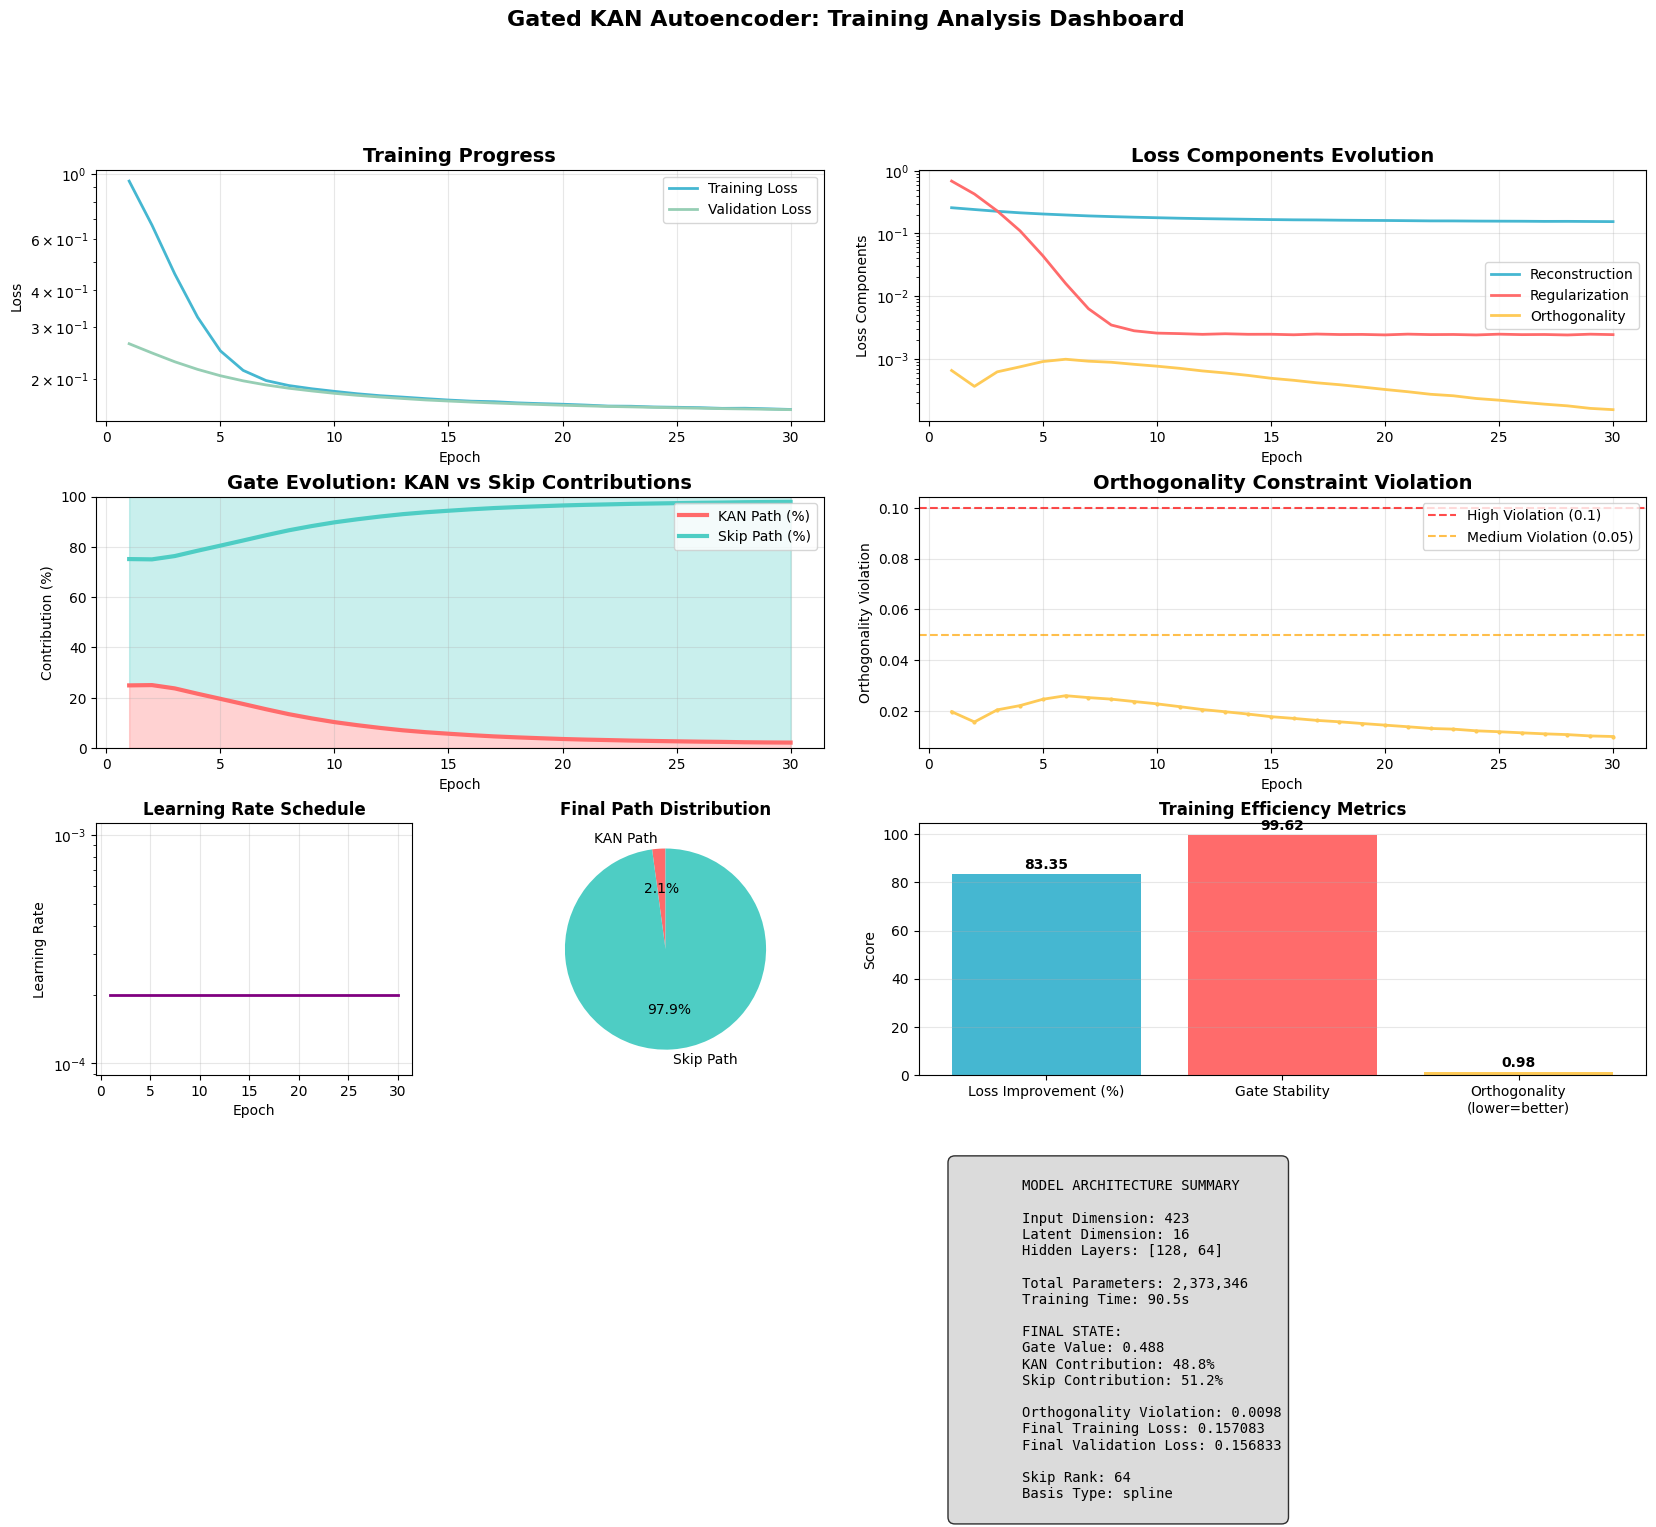


🚪 GATED KAN AUTOENCODER - TRAINING SUMMARY
📈 Loss Improvement: 83.35%
🎛️  Final Gate: KAN=48.8% | Skip=51.2%
🔀 Orthogonality Violation: 0.0098
⏱️  Training Time: 90.5s
🎯 Best Validation Loss: 0.156833


In [ ]:
kan_gated.plot_training_analysis(history_gated)

In [ ]:
latent = kan_gated.get_latent_representation(full_data["train"]["X"])

In [ ]:
latent

tensor([[ 0.0083,  0.0017, -0.0109,  ..., -0.0017,  0.0122,  0.0010],
        [ 0.0083,  0.0017, -0.0109,  ..., -0.0017,  0.0122,  0.0010],
        [ 0.0083,  0.0017, -0.0109,  ..., -0.0017,  0.0122,  0.0010],
        ...,
        [ 0.0083,  0.0017, -0.0109,  ..., -0.0017,  0.0122,  0.0010],
        [ 0.0083,  0.0017, -0.0109,  ..., -0.0017,  0.0122,  0.0010],
        [ 0.0083,  0.0017, -0.0109,  ..., -0.0017,  0.0122,  0.0010]],
       device='cuda:0')